# Installing arff

In [92]:
!pip install liac-arff
!pip install optuna

##  Data Loading

In [93]:
import pandas as pd
import arff

In [116]:
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

print(df_sev.ead())
print(df_freq.head())

     IDpol  ClaimAmount
0     1552       995.20
1  1010996      1128.12
2  4024277      1851.11
3  4007252      1204.00
4  4046424      1204.00
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0        1      0.10    D         5       0       55          50   
1    3.0        1      0.77    D         5       0       55          50   
2    5.0        1      0.75    B         6       2       52          50   
3   10.0        1      0.09    B         7       0       46          50   
4   11.0        1      0.84    B         7       0       46          50   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel       76    R72  
4      B12   Diesel       76    R72  
     IDpol  ClaimAmount
0     1552       995.20
1  1010996      1128.12
2  4024277      1851.11
3  4007252      1204.00
4  4046424      1204.00
   IDpol  ClaimNb  Exposure Area 

## Data Preparation

In [96]:
## Aggregate the Claimamount for each contract.
df_sev_aggregated = df_sev.groupby('IDpol')['ClaimAmount'].sum()

# Do a left join and replace nans with zeros.
merged_df = pd.merge(df_freq, df_sev_aggregated, on='IDpol', how='left')
merged_df["ClaimAmount"].fillna(0, inplace=True)


## Data Visualisations

<Axes: >

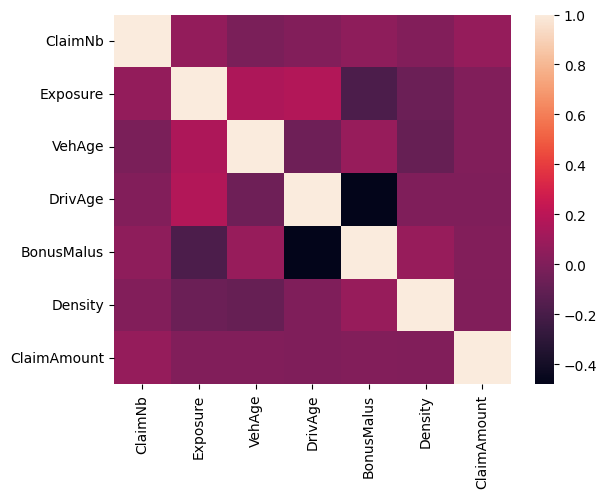

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
# Look into Correlations
corr = merged_df[['ClaimNb', 'Exposure', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'ClaimAmount']].corr()
sns.heatmap(corr)



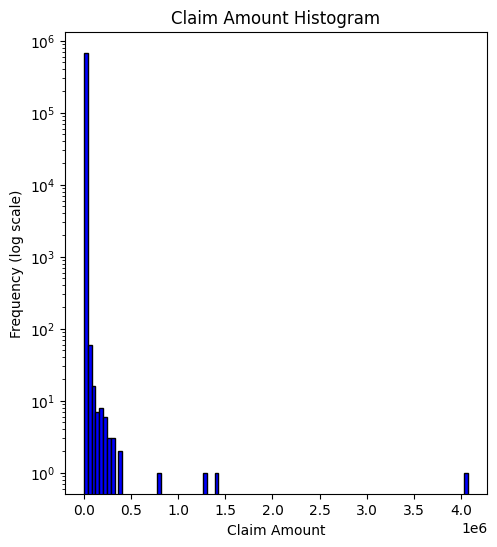

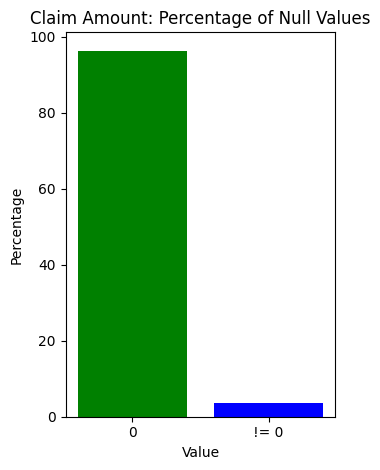

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(12, 6))

# Create a histogram with logarithmic scale on the y-axis
plt.subplot(1, 2, 1)
plt.hist(merged_df["ClaimAmount"], bins=100, color='blue', edgecolor='black')
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title("Claim Amount Histogram")
plt.xlabel("Claim Amount")
plt.ylabel("Frequency (log scale)")
plt.show()



# Calculate the percentage of values that are 0 and not equal to 0
total_values = len(merged_df["ClaimAmount"])
zero_values = len(merged_df[merged_df["ClaimAmount"] == 0])
non_zero_values = total_values - zero_values

percentage_zero = (zero_values / total_values) * 100
percentage_non_zero = (non_zero_values / total_values) * 100

# Create a bar plot for percentages
plt.subplot(1, 2, 2)
plt.bar(['0', '!= 0'], [percentage_zero, percentage_non_zero], color=['green', 'blue'])
plt.title("Claim Amount: Percentage of Null Values")
plt.xlabel("Value")
plt.ylabel("Percentage")

plt.tight_layout()
plt.show()


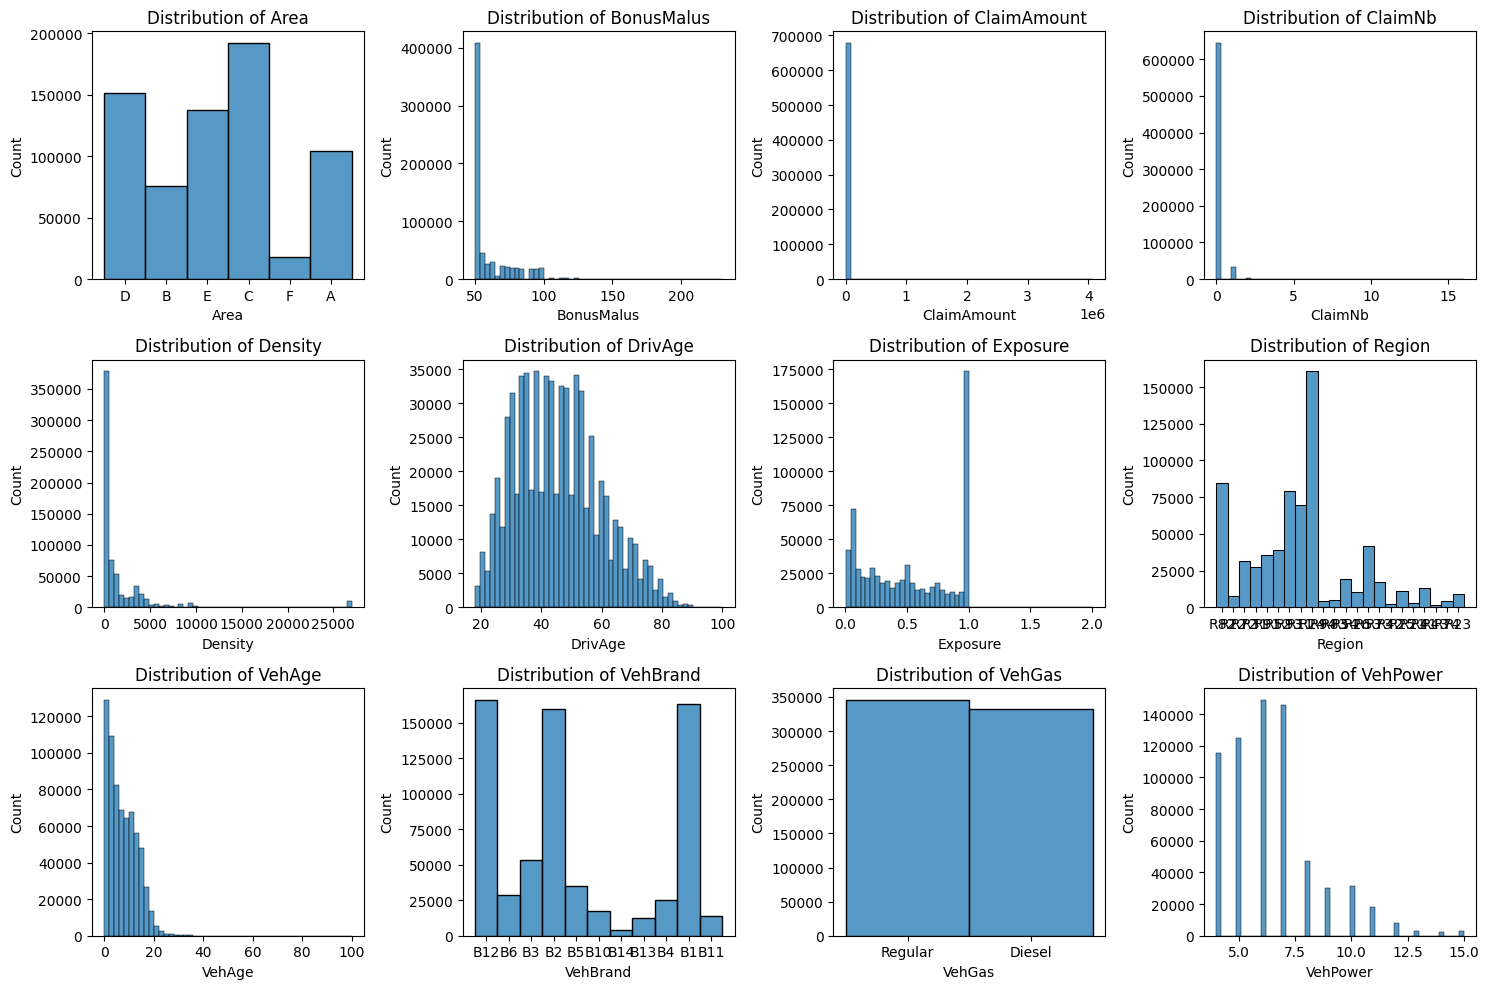

In [99]:
# Exclude 'IDpol' from the columns of interest
columns_of_interest = merged_df.columns.difference(['IDpol'])

# Select the columns of interest
selected_df = merged_df[columns_of_interest]

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot the distributions
for i, column in enumerate(columns_of_interest):
    sns.histplot(selected_df[column], kde=False, ax=axes[i], bins=50)
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout
plt.tight_layout()
plt.show()



## Feature Engineering

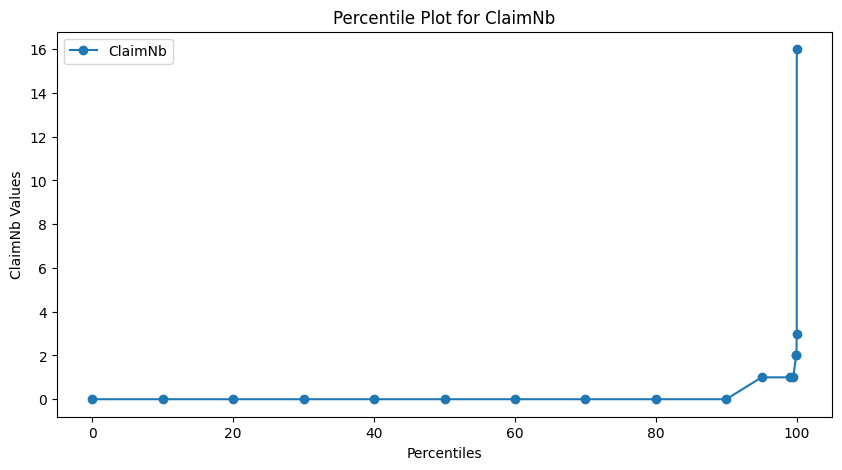

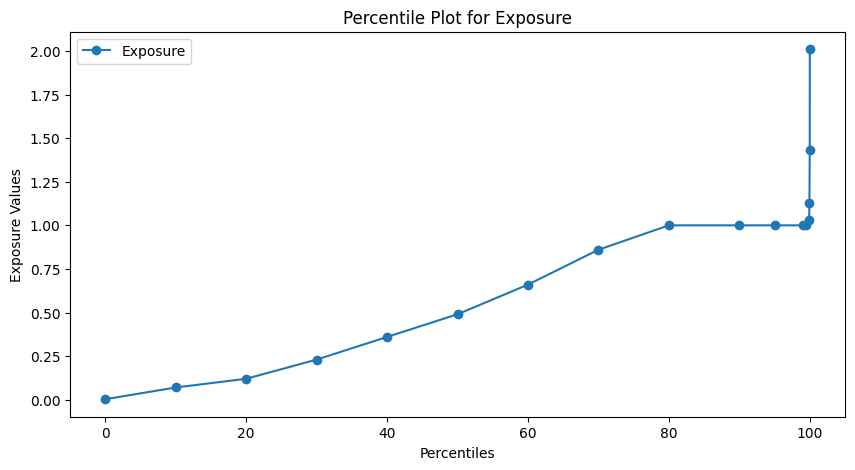

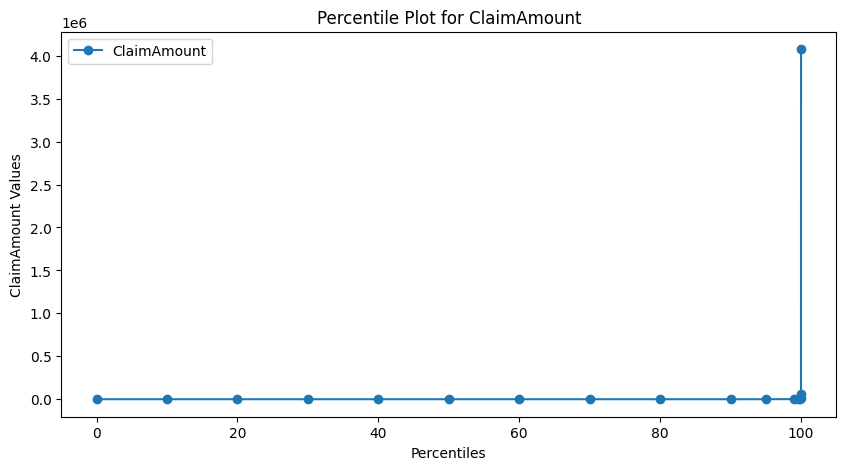

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Look into percentiles to get a reasonable cutoff for outliers.

def plot_percentiles(column_name, percentiles, merged_df):
    percentile_ranks = [np.percentile(merged_df[column_name], p) for p in percentiles]

    plt.figure(figsize=(10, 5))
    plt.plot(percentiles, percentile_ranks, label=column_name, marker='o')
    plt.xlabel('Percentiles')
    plt.ylabel(f'{column_name} Values')
    plt.title(f'Percentile Plot for {column_name}')
    plt.legend()
    plt.show()

# Beispielwerte für die Perzentile
gesuchte_perzentile = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 99.5, 99.9, 99.95, 99.99, 100]

# Plot für ClaimNb
plot_percentiles("ClaimNb", gesuchte_perzentile, merged_df)

# Plot für Exposure
plot_percentiles("Exposure", gesuchte_perzentile, merged_df)

# Plot für ClaimAmount
plot_percentiles("ClaimAmount", gesuchte_perzentile, merged_df)



In [101]:
# Clipping outliers
merged_df["Exposure"] = merged_df["Exposure"].clip(upper=1)
merged_df["ClaimNb"] = merged_df["Exposure"].clip(upper=4)
merged_df["ClaimAmount"] = merged_df["ClaimAmount"].clip(upper=200000)

In [102]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(merged_df)

# Get the Pure Premium as the Claim Amount over the Exposure.
merged_df["PurePremium"] = merged_df["ClaimAmount"] / merged_df["Exposure"]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


## Splitting Data

In [103]:
from sklearn.model_selection import train_test_split
df_train, df_test, X_train, X_test = train_test_split(merged_df, X, random_state=0)


In [104]:
print(df_test["PurePremium"].describe())

count    1.695040e+05
mean     3.112377e+02
std      2.377938e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.102500e+06
Name: PurePremium, dtype: float64


## Modeling

In [112]:
# I decided to model as a Tweedie distribution
from sklearn import linear_model

# Create an instance of TweedieRegressor
clf = linear_model.TweedieRegressor(power = 1.9)

# Fit the model using your training data
clf.fit(X_train, df_train["PurePremium"])

# Make predictions on the test data
out = clf.predict(X_test)

# Since the model is not working, do a very naive prediction (just predicting the mean of Pure Premium of the training data)
# to check if our model is at least doing better than this?

# Calculate the mean of the "PurePremium" column in your training data
mean_pure_premium = np.mean(df_train["PurePremium"])

# Create an array of the same length as `out` with the mean value
naive_out = np.full(len(out), mean_pure_premium)



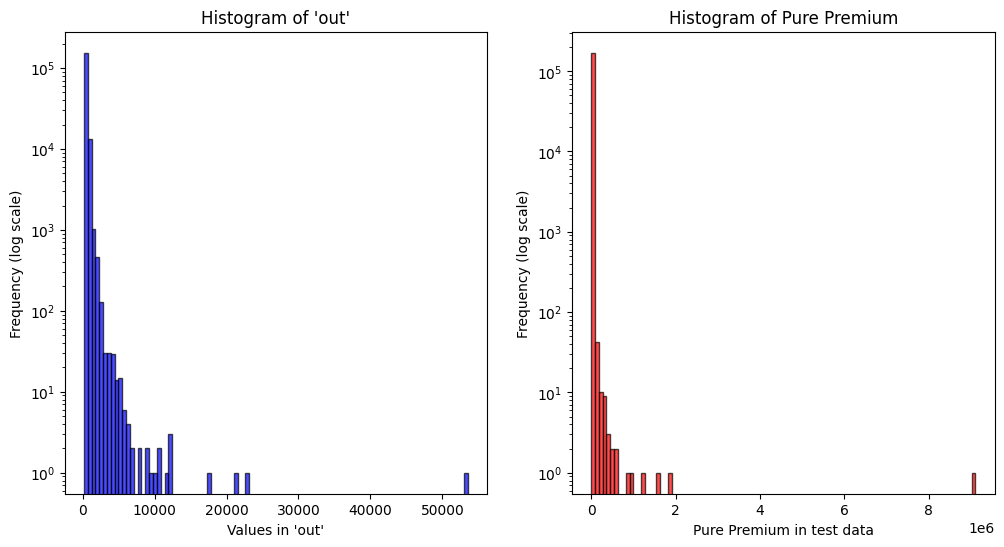

In [109]:
import matplotlib.pyplot as plt

def plot_histograms(out, df_test):
    plt.figure(figsize=(12, 6))

    # Histogram for 'out'
    plt.subplot(1, 2, 1)  # First subplot
    plt.hist(out, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.title("Histogram of 'out'")
    plt.xlabel("Values in 'out'")
    plt.ylabel("Frequency (log scale)")

    # Histogram for 'df_test["PurePremium"]'
    plt.subplot(1, 2, 2)  # Second subplot
    plt.hist(df_test["PurePremium"], bins=100, color='red', edgecolor='black', alpha=0.7)
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.title("Histogram of Pure Premium")
    plt.xlabel("Pure Premium in test data")
    plt.ylabel("Frequency (log scale)")

    plt.show()

plot_histograms(out, df_test)



## Model Evaluation


In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Mean Squared Error for the Regression model is {}".format(mean_squared_error(out, df_test["PurePremium"])))
print("Mean Squared Error for the mean model is {}".format(mean_squared_error(naive_out, df_test["PurePremium"])))
print("Mean Absolute Error for the Regression Model is {}".format(mean_absolute_error(out, df_test["PurePremium"])))
print("Mean Absolute Error for the mean model  is {}".format(mean_absolute_error(naive_out, df_test["PurePremium"])))

Mean Squared Error for the Regression model is 565362892.6925447
Mean Squared Error for the mean model is 565456933.5953006
Mean Absolute Error for the Regression Model is 623.4602457835115
Mean Absolute Error for the mean model  is 637.9655326693332


In [85]:
def plot_predictions_and_targets(y_test, y_pred):

  # Create an index for the x-axis
  x_values = range(len(y_test))
  # Plotting the actual values (y_test) as blue dots
  plt.scatter(x_values, y_test, color='blue', label='Actual (y_test)')
  # Plotting the predicted values (y_pred) as red dots
  plt.scatter(x_values, y_pred, color='red', label='Predicted (y_pred)')
  # Adding labels and title
  plt.xlabel('Examples')
  plt.ylabel('Values')
  plt.title('Actual vs Predicted Values')
  plt.legend()
  # Show the plot
  plt.show()


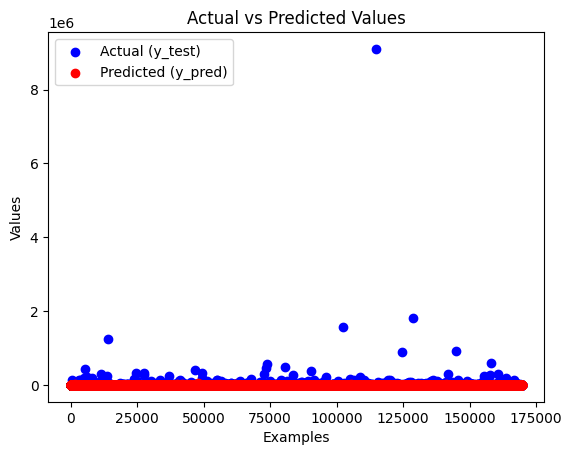

In [86]:
plot_predictions_and_targets(df_test["PurePremium"], out)

In [87]:
## What if we exclude the top 100 values? Does it get better (when not looking at extreme values)?

pure_premium = df_test['PurePremium'].values

# Find the indices of the 100 largest values
indices_to_exclude = np.argsort(pure_premium)[-100:]

# Exclude the extreme values from PurePremium and corresponding values from out
pure_premium_filtered = np.delete(pure_premium, indices_to_exclude)
out_filtered = np.delete(out, indices_to_exclude)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


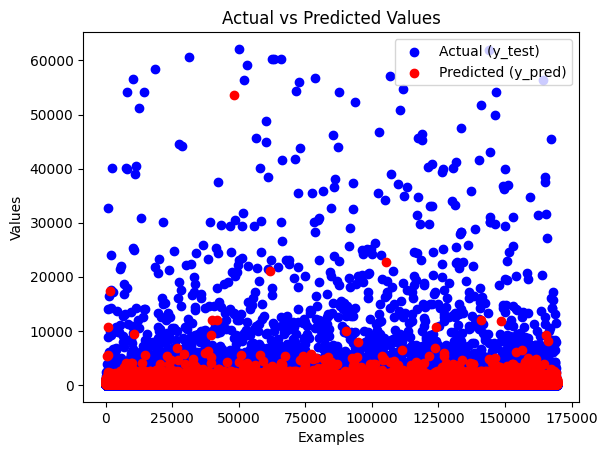

In [88]:
plot_predictions_and_targets(pure_premium_filtered, out_filtered)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Mean Squared Error for the Regression model is {}".format(mean_squared_error(out, df_test["PurePremium"])))
print("Mean Squared Error for the mean model is {}".format(mean_squared_error(naive_out, df_test["PurePremium"])))
print("Mean Absolute Error for the Regression Model is {}".format(mean_absolute_error(out, df_test["PurePremium"])))
print("Mean Absolute Error for the mean model  is {}".format(mean_absolute_error(naive_out, df_test["PurePremium"])))